<a href="https://colab.research.google.com/github/mohanv9/Deeplearning/blob/main/DL_Assignment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Import Libraries/Dataset

In [2]:
# Import required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread
import os

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import time
import seaborn as sns

# Create Datasets
import shutil
#Tuning
#import keras_tuner as kt
from tensorflow import keras


from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

### 1.1 Collecting Data from Kaggle

In [4]:
# Downloading & Unzipping the data - donot run


os.environ['KAGGLE_CONFIG_DIR']= "/content/gdrive/MyDrive/DeepLearning"
"""
This code shall be used to download the data from the kaggle url and
store the data in appropriate locations
"""
%cd /content/gdrive/MyDrive/DeepLearning
#Download kaggle dataset
!kaggle datasets download --force ashishsaxena2209/animal-image-datasetdog-cat-and-panda
# create a new folder
!mkdir AnimalClass
# Move the data to dest folder
!mv animal-image-datasetdog-cat-and-panda.zip AnimalClass
# Enter into the folder & unzip the data
%cd AnimalClass
unzip = !unzip animal-image-datasetdog-cat-and-panda.zip    

/content/gdrive/MyDrive/DeepLearning
 98% 369M/376M [00:03<00:00, 126MB/s]
100% 376M/376M [00:03<00:00, 111MB/s]
/content/gdrive/My Drive/DeepLearning/AnimalClass


# 2. Data Exploration & Preprocessing

## 2.1 Data Visualization and augmentation

  <b> i) Plotting sample images from each class </b>

  <b> ii) Applying Data augmentation and plotting augmented images </b>
  

In [23]:
# Creating a class for visualizing the data
class DataVisualization:
  """
  This class shall be used to dispay the content inside the folder and augmented images

  """
  def __init__(self):
    self.path = '/content/gdrive/MyDrive/DeepLearning/AnimalClass/animals/animals'
    self.categories = ['dogs', 'panda', 'cats']


  def DisplaySamples(self):
    """
    This function shall used to display the few images from the each class
    """
    
    for category in self.categories:
      #plt.figure(figsize=(10,10))
      fig, _ = plt.subplots(1,3, figsize=(10, 10))
      fig.suptitle(category)
      fig.patch.set_facecolor('xkcd:white')
      for k, v in enumerate(os.listdir(self.path+"/"+category)[:3]):
          img = plt.imread(self.path+"/"+category+'/'+v)
          plt.subplot(3, 4, k+1)
          plt.axis('off')
          #plt.figure(figsize=(4,4))
          plt.imshow(img, )
      plt.show()

  def DisplayAugmented(self):
    """
    This function shall used to apply data augmentation on each image class and
    Plots augmented images
    """
    for item in self.categories:
      print(item)
      self.imagepath_main = os.path.join(self.path, item)
      for file in listdir(self.imagepath_main)[4:5]:
        print("printing Original Image: ")
        self.imagepath = self.imagepath_main + '/' + file
        
        image = load_img(self.imagepath)
        plt.imshow(image)
        plt.show()

        print("Printing augmented Images: ")
        image1 = img_to_array(image)
        image2 = np.expand_dims(image,axis=0)

        plt.figure(figsize=(10,10))
        # load the image
        img = load_img(self.imagepath)
        # convert to numpy array
        data = img_to_array(img)
        # expand dimension to one sample
        samples = np.expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(rotation_range=40,
                                    height_shift_range=0.2,
                                    fill_mode='reflect',
                                    zoom_range=0.2)
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot
        for i in range(6):
            # define subplot
            plt.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            # plot raw pixel data
            plt.imshow(image)
        # show the figure
        plt.show()

  def DisplayImageSize(self):
    """
    This function shall used to check the size of all images, whether they are in
    same size or not
    """
    shape0 = []
    shape1 = []

    for category in self.categories:
        for files in os.listdir(self.path+"/"+category):
            shape0.append(plt.imread(self.path+"/"+category+'/'+ files).shape[0])
            shape1.append(plt.imread(self.path+"/"+category+'/'+ files).shape[1])
        print(category, ' => height min : ', min(shape0), 'width min : ', min(shape1))
        print(category, ' => height max : ', max(shape0), 'width max : ', max(shape1))
        shape0 = []
        shape1 = []


In [24]:
dataviz = DataVisualization()

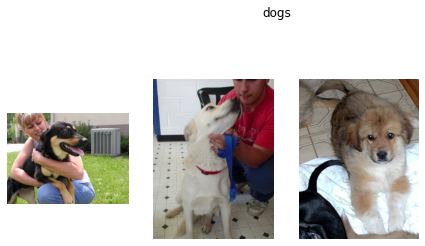

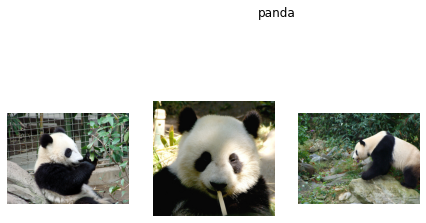

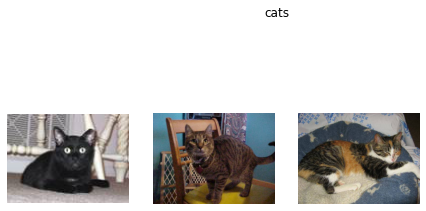

In [25]:
dataviz.DisplaySamples()

dogs
printing Original Image: 


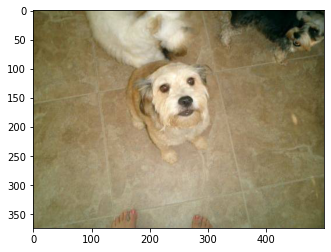

Printing augmented Images: 


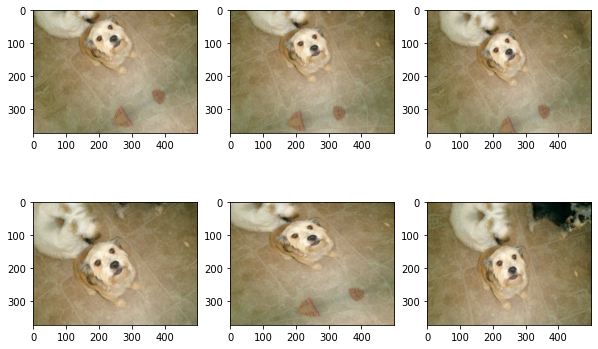

panda
printing Original Image: 


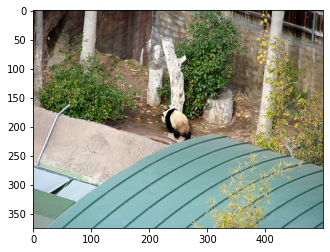

Printing augmented Images: 


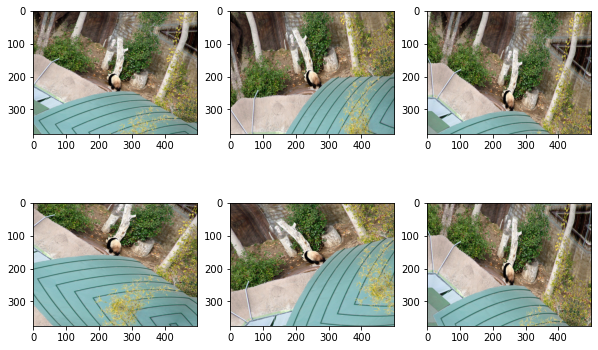

cats
printing Original Image: 


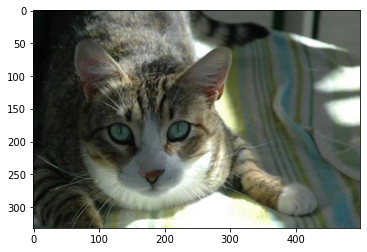

Printing augmented Images: 


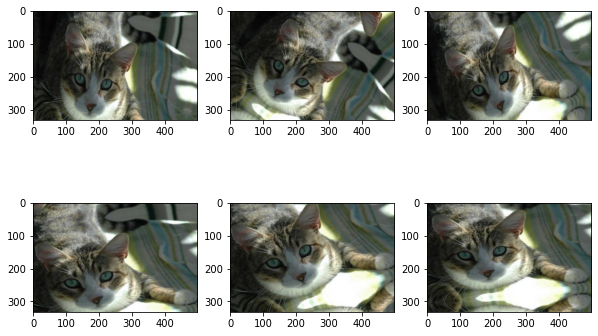

In [26]:
dataviz.DisplayAugmented()

In [14]:
dataviz.DisplayImageSize()

dogs  => height min :  50 width min :  59
dogs  => height max :  500 width max :  500
panda  => height min :  87 width min :  78
panda  => height max :  1200 width max :  1600
cats  => height min :  32 width min :  55
cats  => height max :  500 width max :  500


## 2.2 Train/Test/Validation Split
* Splitting the data into Train, Test and Validation datasets. For this we are creating seperate folder for Train, Test and Validation under new folder called "Final_Dataset". Then we are copying the data into these folder by class wise with the percentage of 70% to the Training, 20% Validation and 10% to the Testing folder. 

In [13]:

# Create new folder and split Data into to Train, test and Validation

class CreateTTV:
  """
  This class shall be used to split the data into Train, Validation and Test set
  and move the data into appropriate locations
  """
  dataset_home = '/content/gdrive/MyDrive/DeepLearning/Final_Dataset/'
  def CreateFolders():
    """
    This function shall used to create new folders for Train, Test, Validation splits
    """
    dataset_home = '/content/gdrive/MyDrive/DeepLearning/Final_Dataset/'
    subdirs = ['train/', 'test/', 'validation/']
    for subdir in subdirs:
      # create label subdirectories
      labeldirs = ['dogs/', 'panda/', 'cats/']
      for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

  def MoveDataTTV():
    """Enumerate all image files into dataset copy them into the dogs/, panda/ or cats/ subdirectory based on their filename.
    Additionally, we can randomly decide to hold back 30% of the images into the test & Validation dataset.
    """
    dataset_home = '/content/gdrive/MyDrive/DeepLearning/Final_Dataset/'
    
    # seed random number generator
    seed(1)
    # define ratio of pictures to use for validation

    test_ratio = 0.10
    val_ratio = 0.20
    # copy training dataset images into subdirectories
    dirs_d = ['dogs', 'panda', 'cats']
    # OriginalData Directory
    src_directory = '/content/gdrive/MyDrive/DeepLearning/AnimalClass/animals/animals'
    for item in dirs_d:
      src = os.path.join(src_directory, item)
      for file in listdir(src):
          sourc = src + '/' + file
          dst_dir = 'train/'
          if random() < test_ratio:
              dst_dir = 'test/'
          if random() < val_ratio:
              dst_dir = 'validation/'
          if item.startswith('cat'):
              dst = dataset_home + dst_dir + 'cats/'  + file
              copyfile(sourc, dst)
              sourc = src + '/'
          elif item.startswith('dog'):
              dst = dataset_home + dst_dir + 'dogs/'  + file
              copyfile(sourc, dst)
              sourc = src + '/'
          elif item.startswith('panda'):
              dst = dataset_home + dst_dir + 'panda/'  + file
              copyfile(sourc, dst)	
              sourc = src + '/'
  def DisplayDataCount(self):
    """
    This function shall used to print the count of the images in Test, train and validation datasets
    """
    self.DATADIR = CreateTTV.dataset_home
    self.CATEGORIES = ['cats', 'dogs', 'panda']

    print('Training: ')
    for i in self.CATEGORIES:
      print('{} images: '.format(i)+str(len(listdir(self.DATADIR + '/train/' + i + '/'))))
    print('\n')
    print('Validation: ')
    for i in self.CATEGORIES:  
      print('{} images: '.format(i)+str(len(listdir(self.DATADIR + '/validation/' + i + '/'))))
    print('\n')
    print('Testing: ')
    for i in self.CATEGORIES:  
      print('{} images: '.format(i)+str(len(listdir(self.DATADIR + '/test/' + i + '/'))))
    print('\n')
    

In [14]:
splitTTV = CreateTTV()

In [15]:
# Printing count of the images available in each new folder
splitTTV.DisplayDataCount()

Training: 
cats images: 724
dogs images: 750
panda images: 693


Validation: 
cats images: 210
dogs images: 177
panda images: 229


Testing: 
cats images: 66
dogs images: 73
panda images: 78




## 2.3 Preprocessing the Data
  <b> i) Bring the Data in the required format </b>
  
  <b> ii) Print the shape of train and test data</b>

In [15]:
 #DATADIR = '/content/gdrive/MyDrive/DeepLearning/Final_Dataset/'
class DataPreprocessing:
  """ 
  This class shall be used to preprocess the images into required format
  """
  DATADIR = '/content/gdrive/MyDrive/DeepLearning/Final_Dataset/'
  def __init__(self):
    pass
  def ImageDataGen(self, IMG_SIZE, BATCH_SIZE):
    """
    This function shall used to bring the data into required format and applies data augmentation each image.
    creating Train, test and validation generators using ImageDataGenerator Keras library
    """
    # Resize the Data
    self.IMG_SIZE = IMG_SIZE
    self.BATCH_SIZE = BATCH_SIZE
    self.train_datagen = ImageDataGenerator(
          rescale=1 / 255.0,
          rotation_range=20,
          zoom_range=0.05,
          width_shift_range=0.05,
          height_shift_range=0.05,
          shear_range=0.05,
          horizontal_flip=True,
          fill_mode="reflect")
    
    self.Validation_datagen = ImageDataGenerator(rescale=1/255.0)

    self.test_datagen = ImageDataGenerator(rescale=1/255.0)

    self.train_generator = self.train_datagen.flow_from_directory(DataPreprocessing.DATADIR + '/train/',
                                                        target_size = (self.IMG_SIZE, self.IMG_SIZE),
                                                        batch_size = self.BATCH_SIZE,
                                                        class_mode = 'binary', #{'categorical', 'binary', 'input', 'sparse', None}
                                                        shuffle=True)

    self.validation_generator = self.Validation_datagen.flow_from_directory(DataPreprocessing.DATADIR + '/validation/',
                                                        target_size = (self.IMG_SIZE, self.IMG_SIZE),
                                                        batch_size = self.BATCH_SIZE,
                                                        class_mode = 'binary',
                                                        shuffle=True)

    self.test_generator = self.test_datagen.flow_from_directory(DataPreprocessing.DATADIR + '/test/',
                                                        target_size = (self.IMG_SIZE, self.IMG_SIZE),
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        shuffle=True)
  def DataShape(self):
    """
    This function shall used to print the shape of the Train and Validation dataset
    """
    # Print the shape
    # for gen in [self.train_generator, self.validation_generator]:
    #   x=np.concatenate([gen.next()[0] for i in range(gen.__len__())])
    #   y=np.concatenate([gen.next()[1] for i in range(gen.__len__())])
    #   if gen == self.train_generator:
    #     print("Training data shape: ")
    #     print(x.shape)
    #     print(y.shape)
    #   else:
    #     print("Validation data shape: ")
    #     print(x.shape)
    #     print(y.shape)
    x=np.concatenate([self.train_generator.next()[0] for i in range(self.train_generator.__len__())])
    y=np.concatenate([self.train_generator.next()[1] for i in range(self.train_generator.__len__())])      
    print("Training data shape: ")
    print(x.shape)
    print(y.shape)
    x=np.concatenate([self.validation_generator.next()[0] for i in range(self.validation_generator.__len__())])
    y=np.concatenate([self.validation_generator.next()[1] for i in range(self.validation_generator.__len__())])      
    print("Validation data shape: ")
    print(x.shape)
    print(y.shape)


In [16]:
Preprocess = DataPreprocessing()

In [17]:
Preprocess.ImageDataGen(100, 96)

Found 2167 images belonging to 3 classes.
Found 616 images belonging to 3 classes.
Found 217 images belonging to 3 classes.


In [18]:
Preprocess.DataShape()

Training data shape: 
(2167, 100, 100, 3)
(2167,)
Validation data shape: 
(616, 100, 100, 3)
(616,)


# 3. Model Creation
  ### 3.1 Model Building
  i) <b> Building Sequential Model </b> - We have used 3 hidden layers for this model and given 1024 neurons for the first layer, 512 neurons for the 2nd layer and 128 neurons for the third hidden layer. 

  ii) <b> L2 Regularization -  </b>Add L2 = 000.1 regularization to all the layers.

  iii) <b> Dropout layer -  </b>

  iv) <b> Activation Function - </b>

  v) <b> Print the model summary </b>

  ### 3.2 Model Compilation
  i) <b> Loss function </b>

  ii) <b> Activation function - Adam </b>

  iii) <b> Used accuracy as a metric</b>


  ### 3.3 Model Training
  i) Training the model for 100 epochs and printing train and validation accuracy and loss for each epoch. Priting time taken for the training

  ii) Plotting accuracy and loss graph for train and validation set.

  ### 3.4 Model Evaluation
  i) Print confusion matrix and classification report for the validation dataset.

  ii) Print the two most incorrectly classified images for each class in the test dataset.

In [117]:
class ModelBuilding(DataPreprocessing):
  """
  This class shall be used to build the model and train the model
  """
  
  def ConstructModel(self, model):
    self.model = model
    self.model = Sequential()
    self.model.add(Flatten(input_shape=(100, 100, 3)))
    self.model.add(Dense(1024,activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)))
    self.model.add(Dense(512,activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)))
    self.model.add(Dropout(0.5))
    self.model.add(Dense(128,activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)))
    #model.add(Dense(64,activation="relu"))

    self.model.add(Dense(3, activation="softmax", ))

    # Plotting Graphical represention of a model
    #import tensorflow.keras
    

    print(self.model.summary())

  #optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
  def compileModel(self, optimizer, loss, metrics):
    #self.model = model
    self.optimizer = optimizer
    self.loss = loss
    self. metrics = metrics
    self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metrics])


  def TrainModel(self, epoch):
    #self.model = model
    super().ImageDataGen(100, 96)
    self.epoch = epoch
    self.history = self.model.fit(self.train_generator,
                    steps_per_epoch = self.train_generator.n // self.BATCH_SIZE,
                    epochs=epoch,
                    verbose=1,
                    validation_data=self.validation_generator,
                    validation_steps = self.validation_generator.n // self.BATCH_SIZE
                    )
    return self.history

  def ModelPredict(self):
    self.prediction = self.model.predict_generator(self.test_generator)
    self.predictions = np.argmax(self.prediction, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(self.test_generator.classes, self.predictions)
    print(cm)
    print('Classification Report')
    print(classification_report(self.test_generator.classes, self.predictions))
    #y_pred = (y_pred > 0.5)
    #cm = confusion_matrix(self.prediction)

    sns.heatmap(cm, annot=True)

  def ModelEvaluate(self):
    #super().ConstructModel()
    self.model.evaluate_generator(self.test_generator, steps=9)
    self.categories = ['cats', 'dogs', 'panda']
    imgs, labels = next(self.test_generator)
    fig = plt.figure(figsize=(10,10))
    columns = 3
    rows = 3
    for i in range(columns * rows):
      fig.add_subplot(rows, columns, i+1)
      img_t = np.expand_dims(imgs[i], axis=0)
      prediction = self.model.predict(img_t)
      idx = prediction[0].tolist().index(max(prediction[0]))
      plt.text(20, 58, self.categories[idx], color='red', fontsize = 10, bbox = dict(facecolor = 'white', alpha = 0.8))
      
      plt.imshow(imgs[i])
  

  

In [118]:
runmodel = ModelBuilding()

In [119]:
runmodel.ConstructModel('model')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              30721024  
_________________________________________________________________
dense_33 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 387       
Total params: 31,311,875
Trainable params: 31,311,875
Non-trainable params: 0
__________________________________________

In [120]:
runmodel.compileModel('adam', 'sparse_categorical_crossentropy', 'accuracy')

In [126]:
start = time.time()
history =  runmodel.TrainModel(72)
print("Total time: ", time.time() - start, "seconds")

Found 2167 images belonging to 3 classes.
Found 616 images belonging to 3 classes.
Found 217 images belonging to 3 classes.
Epoch 1/72
22/22 [==============================] - 16s 710ms/step - loss: 1.3991 - accuracy: 0.4577 - val_loss: 1.1848 - val_accuracy: 0.5573
Epoch 2/72
22/22 [==============================] - 15s 690ms/step - loss: 1.3055 - accuracy: 0.4664 - val_loss: 1.2111 - val_accuracy: 0.5104
Epoch 3/72
22/22 [==============================] - 15s 691ms/step - loss: 1.2475 - accuracy: 0.4887 - val_loss: 1.1544 - val_accuracy: 0.5417
Epoch 4/72
22/22 [==============================] - 15s 684ms/step - loss: 1.2290 - accuracy: 0.5113 - val_loss: 1.1232 - val_accuracy: 0.5503
Epoch 5/72
22/22 [==============================] - 15s 696ms/step - loss: 1.2027 - accuracy: 0.4993 - val_loss: 1.1132 - val_accuracy: 0.5243
Epoch 6/72
22/22 [==============================] - 15s 692ms/step - loss: 1.1705 - accuracy: 0.5041 - val_loss: 1.0912 - val_accuracy: 0.5833
Epoch 7/72
22/22 [

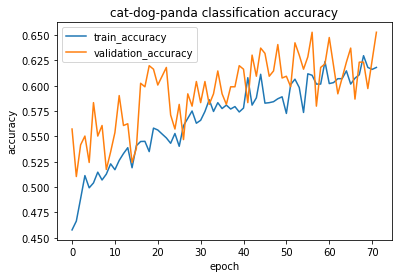

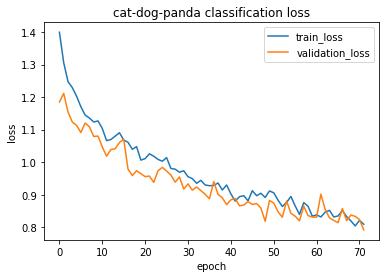

In [127]:
# Model Evaluation

def plot_accuracy(title, history):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
  plt.show()
plot_accuracy("cat-dog-panda classification accuracy", history)
    
def plot_loss(title, history):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

plot_loss("cat-dog-panda classification loss", history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[16 23 27]
 [22 28 23]
 [17 22 39]]
Classification Report
              precision    recall  f1-score   support

           0       0.29      0.24      0.26        66
           1       0.38      0.38      0.38        73
           2       0.44      0.50      0.47        78

    accuracy                           0.38       217
   macro avg       0.37      0.38      0.37       217
weighted avg       0.38      0.38      0.38       217



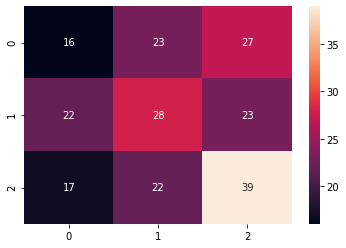

In [128]:
runmodel.ModelPredict()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


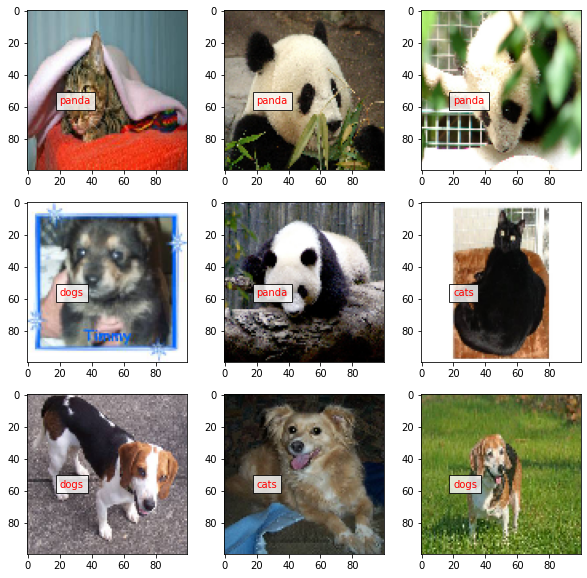

In [130]:
runmodel.ModelEvaluate()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


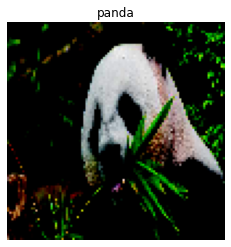

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


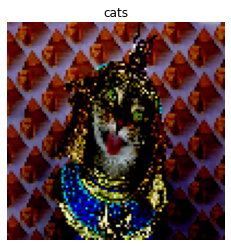

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


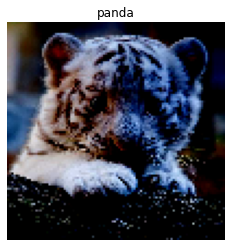

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


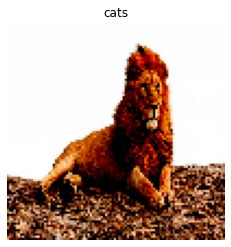

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


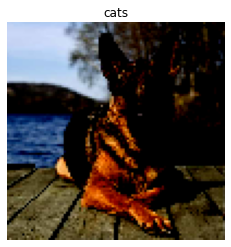

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


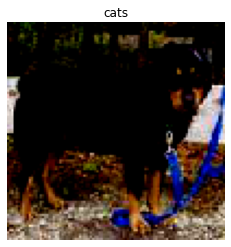

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
def predict_class(model, images, show = True):
  for img in images:
    img = load_img(img, target_size=(100, 100))
    img = img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    CATEGORIES.sort()
    pred_value = CATEGORIES[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = []
# imagepath = '/content/examples/community/en/multi_class_classification/images/'
imagepath = '/content/examples/community/en/multi_class_classification/images/'
images.append('/content/gdrive/MyDrive/DL_Assignment/sample_test/img_01.jpg')
images.append('/content/gdrive/MyDrive/DL_Assignment/sample_test/img_02.jpg')
images.append('/content/gdrive/MyDrive/DL_Assignment/sample_test/img_03.jpg')
images.append('/content/gdrive/MyDrive/DL_Assignment/sample_test/img_04.jpg')
images.append('/content/gdrive/MyDrive/DL_Assignment/sample_test/img_05.jpg')
images.append('/content/gdrive/MyDrive/DL_Assignment/Final_Dataset/test/dogs/dogs_00518.jpg')
predict_class(model, images, True)